In [483]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import confusion_matrix

## Data preprocessing

In [484]:
# load data
def load_npydata(filepath, filename):
    x = np.load(filepath+filename,mmap_mode = 'r')
    return x

# compress from 2000 to 200  ratio = 0.1
def resize(array,ratio):
    r_npy_array = []
    for img in array:
        width = img.shape[0]
        hight = img.shape[1]
        img = Image.fromarray(img)
        imgr =  img.resize( (int(width*ratio) , int(hight*ratio)), Image.ANTIALIAS)
        img_array200 =  np.array(imgr)
        r_npy_array.append(img_array200)

    resule = np.array(r_npy_array)
    return result

# add a "0" to filename list for sorting
def add0sort (tlist):
    for i in range(len(tlist)):
        if len(tlist[i]) == 22:
            tlist[i] = tlist[i][0:7]+"0"+tlist[i][7:]
    tlist.sort()
    return tlist

# delete 0 from sorted filename list
def delete0 (t0list):
    for i in range(len(t0list)):
        if t0list[i][7] == "0":
            t0list[i] = t0list[i][0:7]+t0list[i][8:]
#             print(tlist[i])
    return t0list

# load train data
def load_dataset(tlist,folder):
    path = './/11.7version//'
    X = []
    for i in range(len(tlist)):
        X.append(load_npydata( path+folder ,tlist[i]))
    X = np.array(X)
    return X

In [485]:
# load data list

train_list = os.listdir('.//11.7version//train')
test_list = os.listdir('.//11.7version//test')
train_list = np.array(train_list)
test_list = np.array(test_list)
# print('A_Hour_003_Band_09.npy' in train_list)

train_list1 = train_list.copy()
test_list1 = test_list.copy()
train_list2 = add0sort(train_list1)
test_list2 = add0sort(test_list1)
# print('A_Hour_003_Band_09.npy' in train_list2)

train_list3 = train_list2.copy()
test_list3 = test_list2.copy()
train_list4 = delete0(train_list3)
test_list4 = delete0(test_list3)
# print('A_Hour_003_Band_09.npy' in train_list4)

print(train_list2[0])
print(train_list4[0])

train_list5 = train_list4.copy()
test_list5 = test_list4.copy()

X_train = load_dataset(train_list5,'train//')
X_test = load_dataset(test_list5,'test//')

print(X_train.shape)
print(X_test.shape)

A_Hour_0148_Band_09.npy
A_Hour_148_Band_09.npy
(374, 2000, 2000)
(99, 2000, 2000)


In [486]:
# read label
train_label_df = pd.read_csv(".//11.7version//train.csv")
test_label_df = pd.read_csv(".//11.7version//test.csv")
train_label = train_label_df.values
test_label = test_label_df.values

# find missing value
# train_list2 is the filename which added"0" and sorted

n=0
missingValue = []
for i in range(0,len(train_list2)):
    if train_list2[i][7]=="0":
        if train_list2[i][8:11] != str(train_label[i+n][0]):
            n+=1
            
            missingValue.append(train_label[i+n][0])
              
    elif train_list2[i][7]=="1":
        
        if train_list2[i][7:11] != str(train_label[i+n][0]):
            n+=1
            
            missingValue.append(train_label[i+n][0])
print(missingValue)


# delete the rows that not exist in the train dataset
m = 0
for i in range(len(train_label_df)):
    if train_label_df.iloc[i-m][0] in missingValue:
        train_label_df=train_label_df.drop([i-m])
        m += 1
             
Y_train = train_label_df.iloc[:,1].values
Y_test= test_label_df.iloc[:,1].values
print(Y_train.shape)
print(Y_test.shape)

[295, 297, 299, 396, 418, 420]
(374,)
(99,)


In [487]:
# compress 2000 to 200
X_train200 = resize(X_train,0.1)
X_test200 = resize(X_test,0.1)
    
print(X_train200.shape)
print(X_test200.shape)

(374, 200, 200)
(99, 200, 200)


In [488]:
# add a new axis
X_train = X_train200[:, :, :, np.newaxis]
X_test = X_test200[:, :, :, np.newaxis]
print("X_train shape:", X_train.shape)

# normalization
X_train_01 = X_train / 255.0
X_test_01 = X_test / 255.0

X_train shape: (374, 200, 200, 1)


In [489]:
# one-hot-coding
type_labels = len(np.unique(Y_train))
Y_train = keras.utils.to_categorical(Y_train-1, type_labels) 
Y_test = keras.utils.to_categorical(Y_test-1, type_labels)
print(Y_train.shape)
print(Y_test.shape)

[1 2]
Counter({2: 187, 1: 187})
(374, 2)
(99, 2)


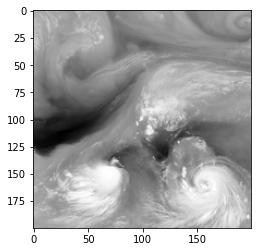

In [490]:
plt.imshow(X_train[0,:,:,0], cmap = 'gray')

## model

In [491]:
# build model
model=Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(200,200, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))





In [505]:
adam = keras.optimizers.Adam(lr = 1e-4,beta_1 = 0.9,beta_2 = 0.999,epsilon = 1e-8)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

# keras.optimizers.RMSprop(1e-4, decay=1e-6)

In [506]:
history=model.fit(X_train_01,Y_train,batch_size=200,epochs=200,verbose=1,validation_data=(X_test_01,Y_test))

Train on 374 samples, validate on 99 samples
Epoch 1/200
374/374 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.6497 - val_loss: 0.6645 - val_accuracy: 0.4848
Epoch 2/200
374/374 [==============================] - 1s 2ms/step - loss: 0.6492 - accuracy: 0.6203 - val_loss: 0.6351 - val_accuracy: 0.7273
Epoch 3/200
374/374 [==============================] - 1s 2ms/step - loss: 0.6290 - accuracy: 0.6658 - val_loss: 0.6728 - val_accuracy: 0.4848
Epoch 4/200
374/374 [==============================] - 1s 2ms/step - loss: 0.6361 - accuracy: 0.6150 - val_loss: 0.6817 - val_accuracy: 0.4848
Epoch 5/200
374/374 [==============================] - 1s 2ms/step - loss: 0.6165 - accuracy: 0.6524 - val_loss: 0.6450 - val_accuracy: 0.5960
Epoch 6/200
374/374 [==============================] - 1s 2ms/step - loss: 0.5952 - accuracy: 0.7246 - val_loss: 0.6203 - val_accuracy: 0.7677
Epoch 7/200
374/374 [==============================] - 1s 2ms/step - loss: 0.6032 - accuracy: 0.6

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


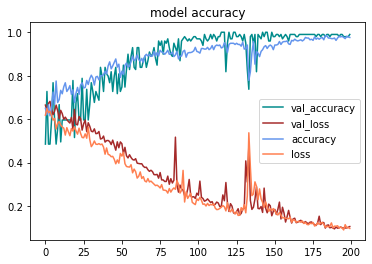

In [507]:
print(history.history.keys())
plt.plot(history.history['val_accuracy'], color = '#008B8B')
plt.plot(history.history['val_loss'],color = '#A52A2A')
plt.plot(history.history['accuracy'],color = '#6495ED')
plt.plot(history.history['loss'],color = '#FF7F50')
plt.title('model accuracy')
plt.legend(["val_accuracy","val_loss", 'accuracy','loss' ])
plt.show()

predicted output:  [[1. 0.]]
the label is:  [1. 0.]


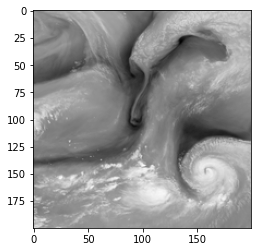

In [515]:
# show an example
csindex = 12
plt.imshow(X_test[csindex,:,:,:], cmap = 'gray')
output_CIFAR=model.predict(X_test[csindex,:,:,:].reshape(1,200,200,1))

print("predicted output: ",np.round(output_CIFAR)) #  round
print("the label is: ", Y_test[csindex])

In [509]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot confusion matrix
def plot_confuse(model, x_val, y_val):
    predictions = model.predict_classes(x_val)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1))

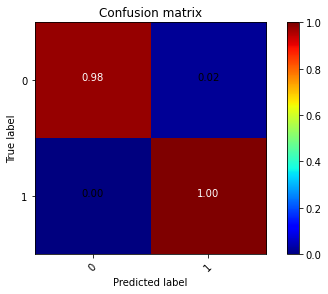

In [510]:
import itertools
plot_confuse(model, X_test_01, Y_test)

In [511]:
# plot confusion matrix
cm = np.zeros([2,2])
for index in range(len(X_test_01)):
    cm_output = model.predict(X_test_01[index,:,:,:].reshape(1,200,200,1))
    j=np.argmax(cm_output)
    i=np.argmax(Y_test[index])
    cm[i][j] += 1
    
print(cm)

[[47.  1.]
 [ 0. 51.]]
